In [1]:
## column additions
## elevation change -- ALP - done -----------------------------------
## latitude - longitude distance -- ALP - done ----------------------
## continent - continent code -- ERIC
## country to country code -- SAEID- done----------------------------
## airport to airport code -- ERIC 
## flighttime -- ALP - done -----------------------------------------
## average speed flighttime/distance -- ALP -------------------------
## company name -- ALP - done ---------------------------------------

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import math


from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (11, 7)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna 

# Feel free to add all the libraries you need
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from geopy.distance import geodesic


In [3]:

# Importing airports data and saving it to a csv file
import airportsdata
airports = airportsdata.load('IATA')

# Filling the missing the airport information for SXF with the data of BER
airports['SXF'] = {'icao': 'EDDB',
 'iata': 'SXF',
 'name': 'Berlin Schonefeld Airport',
 'city': 'Berlin',
 'subd': 'Brandenburg',
 'country': 'DE',
 'elevation': 156.0,
 'lat': 52.362167,
 'lon': 13.500667,
 'tz': 'Europe/Berlin',
 'lid': ''}

airports_df = pd.DataFrame(airports).T
airports_df.to_csv('data/airportdata.csv', index=True)

In [4]:
# df['datop']=pd.to_datetime(df['datop'])
# df

In [5]:

# Import flight data and airport data
df_flightdata = pd.read_csv('data/Train.csv')
df_airportdata = pd.read_csv('data/airportdata.csv',index_col=0)

# # Converting to the right datatype
df_flightdata['STA'] = pd.to_datetime(df_flightdata['STA'], format='%Y-%m-%d %H.%M.%S')
df_flightdata['STD'] = pd.to_datetime(df_flightdata['STD'], format='%Y-%m-%d %H:%M:%S')
#df_flightdata['DATOP'] = pd.to_datetime(df_flightdata['DATOP'], format='%Y-%m-%d')
###############################################################################################################
df_flightdata['DATOP'] = pd.to_datetime(df_flightdata['DATOP'], format='%Y-%m-%d')

# Extract year, month, and day components
df_flightdata['year'] = df_flightdata['DATOP'].dt.year
df_flightdata['month'] = df_flightdata['DATOP'].dt.month
df_flightdata['day'] = df_flightdata['DATOP'].dt.day

# Print the modified DataFrame
df_flightdata

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,year,month,day
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,2016,1,3
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,2016,1,13
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,2016,1,16
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,2016,1,17
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,2016,1,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107828,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02:00:00,SCH,TU 32AIML,0.0,2018,7,5
107829,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09:00:00,SCH,UG AT7AT7,0.0,2018,1,13
107830,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12:50:00,SCH,TU 736IOK,0.0,2018,11,7
107831,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18:45:00,ATA,TU CR9ISA,0.0,2018,1,23


In [6]:
# Merge df with departure airport data
df = df_flightdata.join(df_airportdata[['iata', 'country', 'elevation', 'lat', 'lon']].add_prefix('dep_'), how='left', on='DEPSTN')
df = df.join(df_airportdata[['iata', 'country', 'elevation', 'lat', 'lon']].add_prefix('arr_'), how='left', on='ARRSTN')
# Merge df with arrival airport data
display(df.head().T)

,0,1,2,3,4
ID,train_id_0,train_id_1,train_id_2,train_id_3,train_id_4
DATOP,2016-01-03 00:00:00,2016-01-13 00:00:00,2016-01-16 00:00:00,2016-01-17 00:00:00,2016-01-17 00:00:00
FLTID,TU 0712,TU 0757,TU 0214,TU 0480,TU 0338
DEPSTN,CMN,MXP,TUN,DJE,TUN
ARRSTN,TUN,TUN,IST,NTE,ALG
STD,2016-01-03 10:30:00,2016-01-13 15:05:00,2016-01-16 04:10:00,2016-01-17 14:10:00,2016-01-17 14:30:00
STA,2016-01-03 12:55:00,2016-01-13 16:55:00,2016-01-16 06:45:00,2016-01-17 17:00:00,2016-01-17 15:50:00
STATUS,ATA,ATA,ATA,ATA,ATA
AC,TU 32AIMN,TU 31BIMO,TU 32AIMN,TU 736IOK,TU 320IMU
target,260.0,20.0,0.0,0.0,22.0


In [7]:
# # Create a sample DataFrame
# data = {'STD': ['2016-01-03 10:30:00', '2016-01-13 15:05:00', '2016-01-16 04:10:00',
#                 '2016-01-17 14:10:00', '2016-01-17 14:30:00'],
#         'STA': ['2016-01-03 12:30:00', '2016-01-13 18:05:00', '2016-01-16 06:10:00',
#                 '2016-01-17 16:10:00', '2016-01-17 16:30:00']}
# df = pd.DataFrame(data)

# # Convert 'STD' column to datetime format
# df['STD'] = pd.to_datetime(df['STD'])
# df['STA'] = pd.to_datetime(df['STA'])

# # Extract time component
# df['Time'] = df['STD'].dt.time
# df['Time'] = df['STA'].dt.time

# # Drop the original 'STD' column if needed
# df = df.drop(columns=['STD'])
# df = df.drop(columns=['STA'])

# # Print the modified DataFrame
# print(df)

In [8]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,107823,107824,107825,107826,107827,107828,107829,107830,107831,107832
ID,train_id_0,train_id_1,train_id_2,train_id_3,train_id_4,train_id_5,train_id_6,train_id_7,train_id_8,train_id_9,...,train_id_107823,train_id_107824,train_id_107825,train_id_107826,train_id_107827,train_id_107828,train_id_107829,train_id_107830,train_id_107831,train_id_107832
DATOP,2016-01-03 00:00:00,2016-01-13 00:00:00,2016-01-16 00:00:00,2016-01-17 00:00:00,2016-01-17 00:00:00,2016-01-17 00:00:00,2016-01-18 00:00:00,2016-01-18 00:00:00,2016-01-18 00:00:00,2016-01-18 00:00:00,...,2018-04-12 00:00:00,2018-02-09 00:00:00,2018-08-08 00:00:00,2018-10-15 00:00:00,2018-12-19 00:00:00,2018-07-05 00:00:00,2018-01-13 00:00:00,2018-11-07 00:00:00,2018-01-23 00:00:00,2018-11-13 00:00:00
FLTID,TU 0712,TU 0757,TU 0214,TU 0480,TU 0338,TU 0283,TU 0514,TU 0716,TU 0752,TU 0996,...,TU 9001,UG 1730,WKL 0000,UG 0011,SGT 0000,WKL 0000,UG 0003,SGT 0000,UG 0010,UG 0002
DEPSTN,CMN,MXP,TUN,DJE,TUN,TLS,TUN,TUN,TUN,TUN,...,MIR,TUN,TUN,DJE,TUN,TUN,DJE,TUN,TUN,TUN
ARRSTN,TUN,TUN,IST,NTE,ALG,TUN,BCN,ORY,FCO,NCE,...,TUN,NAP,TUN,TUN,TUN,TUN,TUN,TUN,DJE,DJE
STD,2016-01-03 10:30:00,2016-01-13 15:05:00,2016-01-16 04:10:00,2016-01-17 14:10:00,2016-01-17 14:30:00,2016-01-17 16:20:00,2016-01-18 07:15:00,2016-01-18 07:35:00,2016-01-18 07:40:00,2016-01-18 07:45:00,...,2018-04-12 17:05:00,2018-02-09 10:00:00,2018-08-08 22:00:00,2018-10-15 19:45:00,2018-12-19 23:45:00,2018-07-05 23:00:00,2018-01-13 08:00:00,2018-11-07 05:00:00,2018-01-23 18:00:00,2018-11-13 06:15:00
STA,2016-01-03 12:55:00,2016-01-13 16:55:00,2016-01-16 06:45:00,2016-01-17 17:00:00,2016-01-17 15:50:00,2016-01-17 18:15:00,2016-01-18 09:00:00,2016-01-18 09:55:00,2016-01-18 09:00:00,2016-01-18 09:15:00,...,2018-04-12 17:40:00,2018-02-09 11:15:00,2018-08-09 01:00:00,2018-10-15 20:45:00,2018-12-20 01:45:00,2018-07-06 02:00:00,2018-01-13 09:00:00,2018-11-07 12:50:00,2018-01-23 18:45:00,2018-11-13 07:05:00
STATUS,ATA,ATA,ATA,ATA,ATA,ATA,ATA,ATA,ATA,ATA,...,ATA,SCH,SCH,SCH,SCH,SCH,SCH,SCH,ATA,SCH
AC,TU 32AIMN,TU 31BIMO,TU 32AIMN,TU 736IOK,TU 320IMU,TU 736IOP,TU 32AIMH,TU 32AIMI,TU 32AIMC,TU 31AIMK,...,TU 736IOL,TU CR9ISA,TU 320IMV,UG AT7LBE,TU 736IOP,TU 32AIML,UG AT7AT7,TU 736IOK,TU CR9ISA,TU CR9ISA
target,260.0,20.0,0.0,0.0,22.0,53.0,10.0,15.0,16.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df['year'].unique()


array([2016, 2017, 2018])

In [10]:
df.head(2)

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,...,dep_iata,dep_country,dep_elevation,dep_lat,dep_lon,arr_iata,arr_country,arr_elevation,arr_lat,arr_lon
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,...,CMN,MA,656.0,33.3675,-7.58997,TUN,TN,22.0,36.851002,10.2272
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,...,MXP,IT,768.0,45.6306,8.72811,TUN,TN,22.0,36.851002,10.2272


In [11]:
# FIX COLUMN NAMES Function - general function build out with time
def fix_column_names(input_dataset):
    infun_data = input_dataset
    # pull the starting columns to show at the end the transformation 
    starting_columns = list(infun_data.columns)
    # carry out the changes; remove spaces and hyphens, lower case everything
    infun_data.columns = infun_data.columns.str.replace(' ','_')
    infun_data.columns = infun_data.columns.str.lower()
    infun_data.columns = infun_data.columns.str.replace('-', '_')
    # pull the ending columns to show at the end the transformation 
    ending_columns = list(infun_data.columns)
    # create a dictionary of the old names vs the new names 
    dict_of_names = {'old column name': starting_columns, 'new column name': ending_columns}
    dataframe_of_column_names = df = pd.DataFrame(dict_of_names) 
    print(dataframe_of_column_names)
    return infun_data

df = fix_column_names(df)

   old column name new column name
0               ID              id
1            DATOP           datop
2            FLTID           fltid
3           DEPSTN          depstn
4           ARRSTN          arrstn
5              STD             std
6              STA             sta
7           STATUS          status
8               AC              ac
9           target          target
10            year            year
11           month           month
12             day             day
13        dep_iata        dep_iata
14     dep_country     dep_country
15   dep_elevation   dep_elevation
16         dep_lat         dep_lat
17         dep_lon         dep_lon
18        arr_iata        arr_iata
19     arr_country     arr_country
20   arr_elevation   arr_elevation
21         arr_lat         arr_lat
22         arr_lon         arr_lon


In [12]:
# you must make the dataset equal to the function
# i.e. df = del_duplicates(df)
def del_duplicates(input_dataset):
    # check for duplicates 
    print(input_dataset.duplicated().value_counts())
    # remove duplicates
    input_dataset = input_dataset.drop_duplicates()
    # reset index inplace
    input_dataset.reset_index(inplace=True, drop=True)
    return input_dataset
    
df = del_duplicates(df)

False    107833
Name: count, dtype: int64


In [13]:
# which are statistical continous values?
# which are statistical quantitative values?


# check the different columns
# is a column a unique identifier? 
# can it be dropped to a unique identifier table, 
# i.e. unique identifier and then name, address, ticket number etc. (info table)
# postcode/zipcode an example of a none unique identifier, things that can't be grouped
df.dtypes

def table_nuniques(input_dataset):
    nunique_dictionary = {'column name': [], 'nuniques': [], 'uniques':[], 'dtype' : []}
    infun_data = input_dataset
    columnlist = list(infun_data.columns)
    for i in columnlist: 
        nunique_dictionary['column name'].append(i)
        nunique_dictionary['nuniques'].append(infun_data[i].nunique())        
        nunique_dictionary['uniques'].append(infun_data[i].unique())
        nunique_dictionary['dtype'].append(infun_data[i].dtype)
    # print the dictionary as a dataframe
    return pd.DataFrame(nunique_dictionary)

table_nuniques(df)

,column name,nuniques,uniques,dtype
0,id,107833,"[train_id_0, train_id_1, train_id_2, train_id_...",object
1,datop,1011,"[2016-01-03 00:00:00, 2016-01-13 00:00:00, 201...",datetime64[ns]
2,fltid,1861,"[TU 0712 , TU 0757 , TU 0214 , TU 0480 , TU 03...",object
3,depstn,132,"[CMN, MXP, TUN, DJE, TLS, IST, ORY, MIR, BRU, ...",object
4,arrstn,128,"[TUN, IST, NTE, ALG, BCN, ORY, FCO, NCE, MRS, ...",object
5,std,81697,"[2016-01-03 10:30:00, 2016-01-13 15:05:00, 201...",datetime64[ns]
6,sta,85136,"[2016-01-03 12:55:00, 2016-01-13 16:55:00, 201...",datetime64[ns]
7,status,5,"[ATA, DEP, RTR, SCH, DEL]",object
8,ac,68,"[TU 32AIMN, TU 31BIMO, TU 736IOK, TU 320IMU, T...",object
9,target,968,"[260.0, 20.0, 0.0, 22.0, 53.0, 10.0, 15.0, 16....",float64


In [14]:
#  no na was found!!
print("Null values")
print(df.isnull().sum())
print("="*50)
print("Zero values")
print((df == 0).sum())

Null values
id               0
datop            0
fltid            0
depstn           0
arrstn           0
std              0
sta              0
status           0
ac               0
target           0
year             0
month            0
day              0
dep_iata         0
dep_country      0
dep_elevation    0
dep_lat          0
dep_lon          0
arr_iata         0
arr_country      0
arr_elevation    0
arr_lat          0
arr_lon          0
dtype: int64
Zero values
id                   0
datop                0
fltid                0
depstn               0
arrstn               0
std                  0
sta                  0
status               0
ac                   0
target           38168
year                 0
month                0
day                  0
dep_iata             0
dep_country          0
dep_elevation        0
dep_lat              0
dep_lon              0
arr_iata             0
arr_country          0
arr_elevation        0
arr_lat              0
arr_lon             

In [15]:
# Feature engineering

# Airline names
df['airline_code'] = df['fltid'].str[:2]

# Elevation difference
df['elevation_dif'] = (df['arr_elevation'] - df['dep_elevation'])

# Flight time in minutes
df['flight_time_in_min'] = (df['sta'] - df['std']).dt.total_seconds() / 60

In [16]:
# Distance between departure and arrival airports using the library geodesic
def calculate_distance(row):
    dep_coords = (row['dep_lat'], row['dep_lon'])
    arr_coords = (row['arr_lat'], row['arr_lon'])
    distance = geodesic(dep_coords, arr_coords).kilometers
    return int(round(distance,0))

df['flight_distance_in_km'] = df.apply(calculate_distance, axis=1)

In [17]:
df['flight_distance_in_km']

0         1667
1          983
2         1673
3         1805
4          626
          ... 
107828       0
107829     334
107830       0
107831     334
107832     334
Name: flight_distance_in_km, Length: 107833, dtype: int64

In [18]:
df['average_flight_speed_km_h'] = (df['flight_distance_in_km']*60/df['flight_time_in_min'])
df['average_flight_speed_km_h'] = df['average_flight_speed_km_h'].round().astype(int)


In [19]:
df['international_flight'] = np.where(df['arr_country'] != df['dep_country'], 1, 0)

In [20]:
df['international_flight'].value_counts()

international_flight
1    88932
0    18901
Name: count, dtype: int64

In [21]:
df.head().T

,0,1,2,3,4
id,train_id_0,train_id_1,train_id_2,train_id_3,train_id_4
datop,2016-01-03 00:00:00,2016-01-13 00:00:00,2016-01-16 00:00:00,2016-01-17 00:00:00,2016-01-17 00:00:00
fltid,TU 0712,TU 0757,TU 0214,TU 0480,TU 0338
depstn,CMN,MXP,TUN,DJE,TUN
arrstn,TUN,TUN,IST,NTE,ALG
std,2016-01-03 10:30:00,2016-01-13 15:05:00,2016-01-16 04:10:00,2016-01-17 14:10:00,2016-01-17 14:30:00
sta,2016-01-03 12:55:00,2016-01-13 16:55:00,2016-01-16 06:45:00,2016-01-17 17:00:00,2016-01-17 15:50:00
status,ATA,ATA,ATA,ATA,ATA
ac,TU 32AIMN,TU 31BIMO,TU 32AIMN,TU 736IOK,TU 320IMU
target,260.0,20.0,0.0,0.0,22.0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   id                         107833 non-null  object        
 1   datop                      107833 non-null  datetime64[ns]
 2   fltid                      107833 non-null  object        
 3   depstn                     107833 non-null  object        
 4   arrstn                     107833 non-null  object        
 5   std                        107833 non-null  datetime64[ns]
 6   sta                        107833 non-null  datetime64[ns]
 7   status                     107833 non-null  object        
 8   ac                         107833 non-null  object        
 9   target                     107833 non-null  float64       
 10  year                       107833 non-null  int32         
 11  month                      107833 non-null  int32   

In [23]:
df['std'] = df['std'].dt.time
df['sta'] = df['sta'].dt.time

In [24]:
df['month'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 107833 entries, 0 to 107832
Series name: month
Non-Null Count   Dtype
--------------   -----
107833 non-null  int32
dtypes: int32(1)
memory usage: 421.4 KB


In [25]:


# Create the seasons column
df.loc[(df['month'] < 3) | (df['month'] == 12), 'season'] = 'winter'
df.loc[(df['month'] >= 3) & (df['month'] < 6), 'season'] = 'spring' 
df.loc[(df['month'] >= 6) & (df['month'] < 9), 'season'] = 'summer' 
df.loc[(df['month'] >= 9) & (df['month'] < 12), 'season'] = 'autumn'

# Print the modified DataFrame
df.T

,0,1,2,3,4,5,6,7,8,9,...,107823,107824,107825,107826,107827,107828,107829,107830,107831,107832
id,train_id_0,train_id_1,train_id_2,train_id_3,train_id_4,train_id_5,train_id_6,train_id_7,train_id_8,train_id_9,...,train_id_107823,train_id_107824,train_id_107825,train_id_107826,train_id_107827,train_id_107828,train_id_107829,train_id_107830,train_id_107831,train_id_107832
datop,2016-01-03 00:00:00,2016-01-13 00:00:00,2016-01-16 00:00:00,2016-01-17 00:00:00,2016-01-17 00:00:00,2016-01-17 00:00:00,2016-01-18 00:00:00,2016-01-18 00:00:00,2016-01-18 00:00:00,2016-01-18 00:00:00,...,2018-04-12 00:00:00,2018-02-09 00:00:00,2018-08-08 00:00:00,2018-10-15 00:00:00,2018-12-19 00:00:00,2018-07-05 00:00:00,2018-01-13 00:00:00,2018-11-07 00:00:00,2018-01-23 00:00:00,2018-11-13 00:00:00
fltid,TU 0712,TU 0757,TU 0214,TU 0480,TU 0338,TU 0283,TU 0514,TU 0716,TU 0752,TU 0996,...,TU 9001,UG 1730,WKL 0000,UG 0011,SGT 0000,WKL 0000,UG 0003,SGT 0000,UG 0010,UG 0002
depstn,CMN,MXP,TUN,DJE,TUN,TLS,TUN,TUN,TUN,TUN,...,MIR,TUN,TUN,DJE,TUN,TUN,DJE,TUN,TUN,TUN
arrstn,TUN,TUN,IST,NTE,ALG,TUN,BCN,ORY,FCO,NCE,...,TUN,NAP,TUN,TUN,TUN,TUN,TUN,TUN,DJE,DJE
std,10:30:00,15:05:00,04:10:00,14:10:00,14:30:00,16:20:00,07:15:00,07:35:00,07:40:00,07:45:00,...,17:05:00,10:00:00,22:00:00,19:45:00,23:45:00,23:00:00,08:00:00,05:00:00,18:00:00,06:15:00
sta,12:55:00,16:55:00,06:45:00,17:00:00,15:50:00,18:15:00,09:00:00,09:55:00,09:00:00,09:15:00,...,17:40:00,11:15:00,01:00:00,20:45:00,01:45:00,02:00:00,09:00:00,12:50:00,18:45:00,07:05:00
status,ATA,ATA,ATA,ATA,ATA,ATA,ATA,ATA,ATA,ATA,...,ATA,SCH,SCH,SCH,SCH,SCH,SCH,SCH,ATA,SCH
ac,TU 32AIMN,TU 31BIMO,TU 32AIMN,TU 736IOK,TU 320IMU,TU 736IOP,TU 32AIMH,TU 32AIMI,TU 32AIMC,TU 31AIMK,...,TU 736IOL,TU CR9ISA,TU 320IMV,UG AT7LBE,TU 736IOP,TU 32AIML,UG AT7AT7,TU 736IOK,TU CR9ISA,TU CR9ISA
target,260.0,20.0,0.0,0.0,22.0,53.0,10.0,15.0,16.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# #Create the seasons column 
# for data in df:
#     data.loc[ (data['month'] < 3) | (data['month'] == 12), 'season'] = 'winter'
#     data.loc[(data['month'] >= 3) & (data['month'] < 6), 'season' ] = 'Spring' 
#     data.loc[(data['month'] >= 6) & (data['month'] < 9), 'season']='summer' 
#     data.loc[(data['month'] >= 9) & (data['month'] < 12), 'season'] = 'Autumn'
#     data['season'] = data['season']

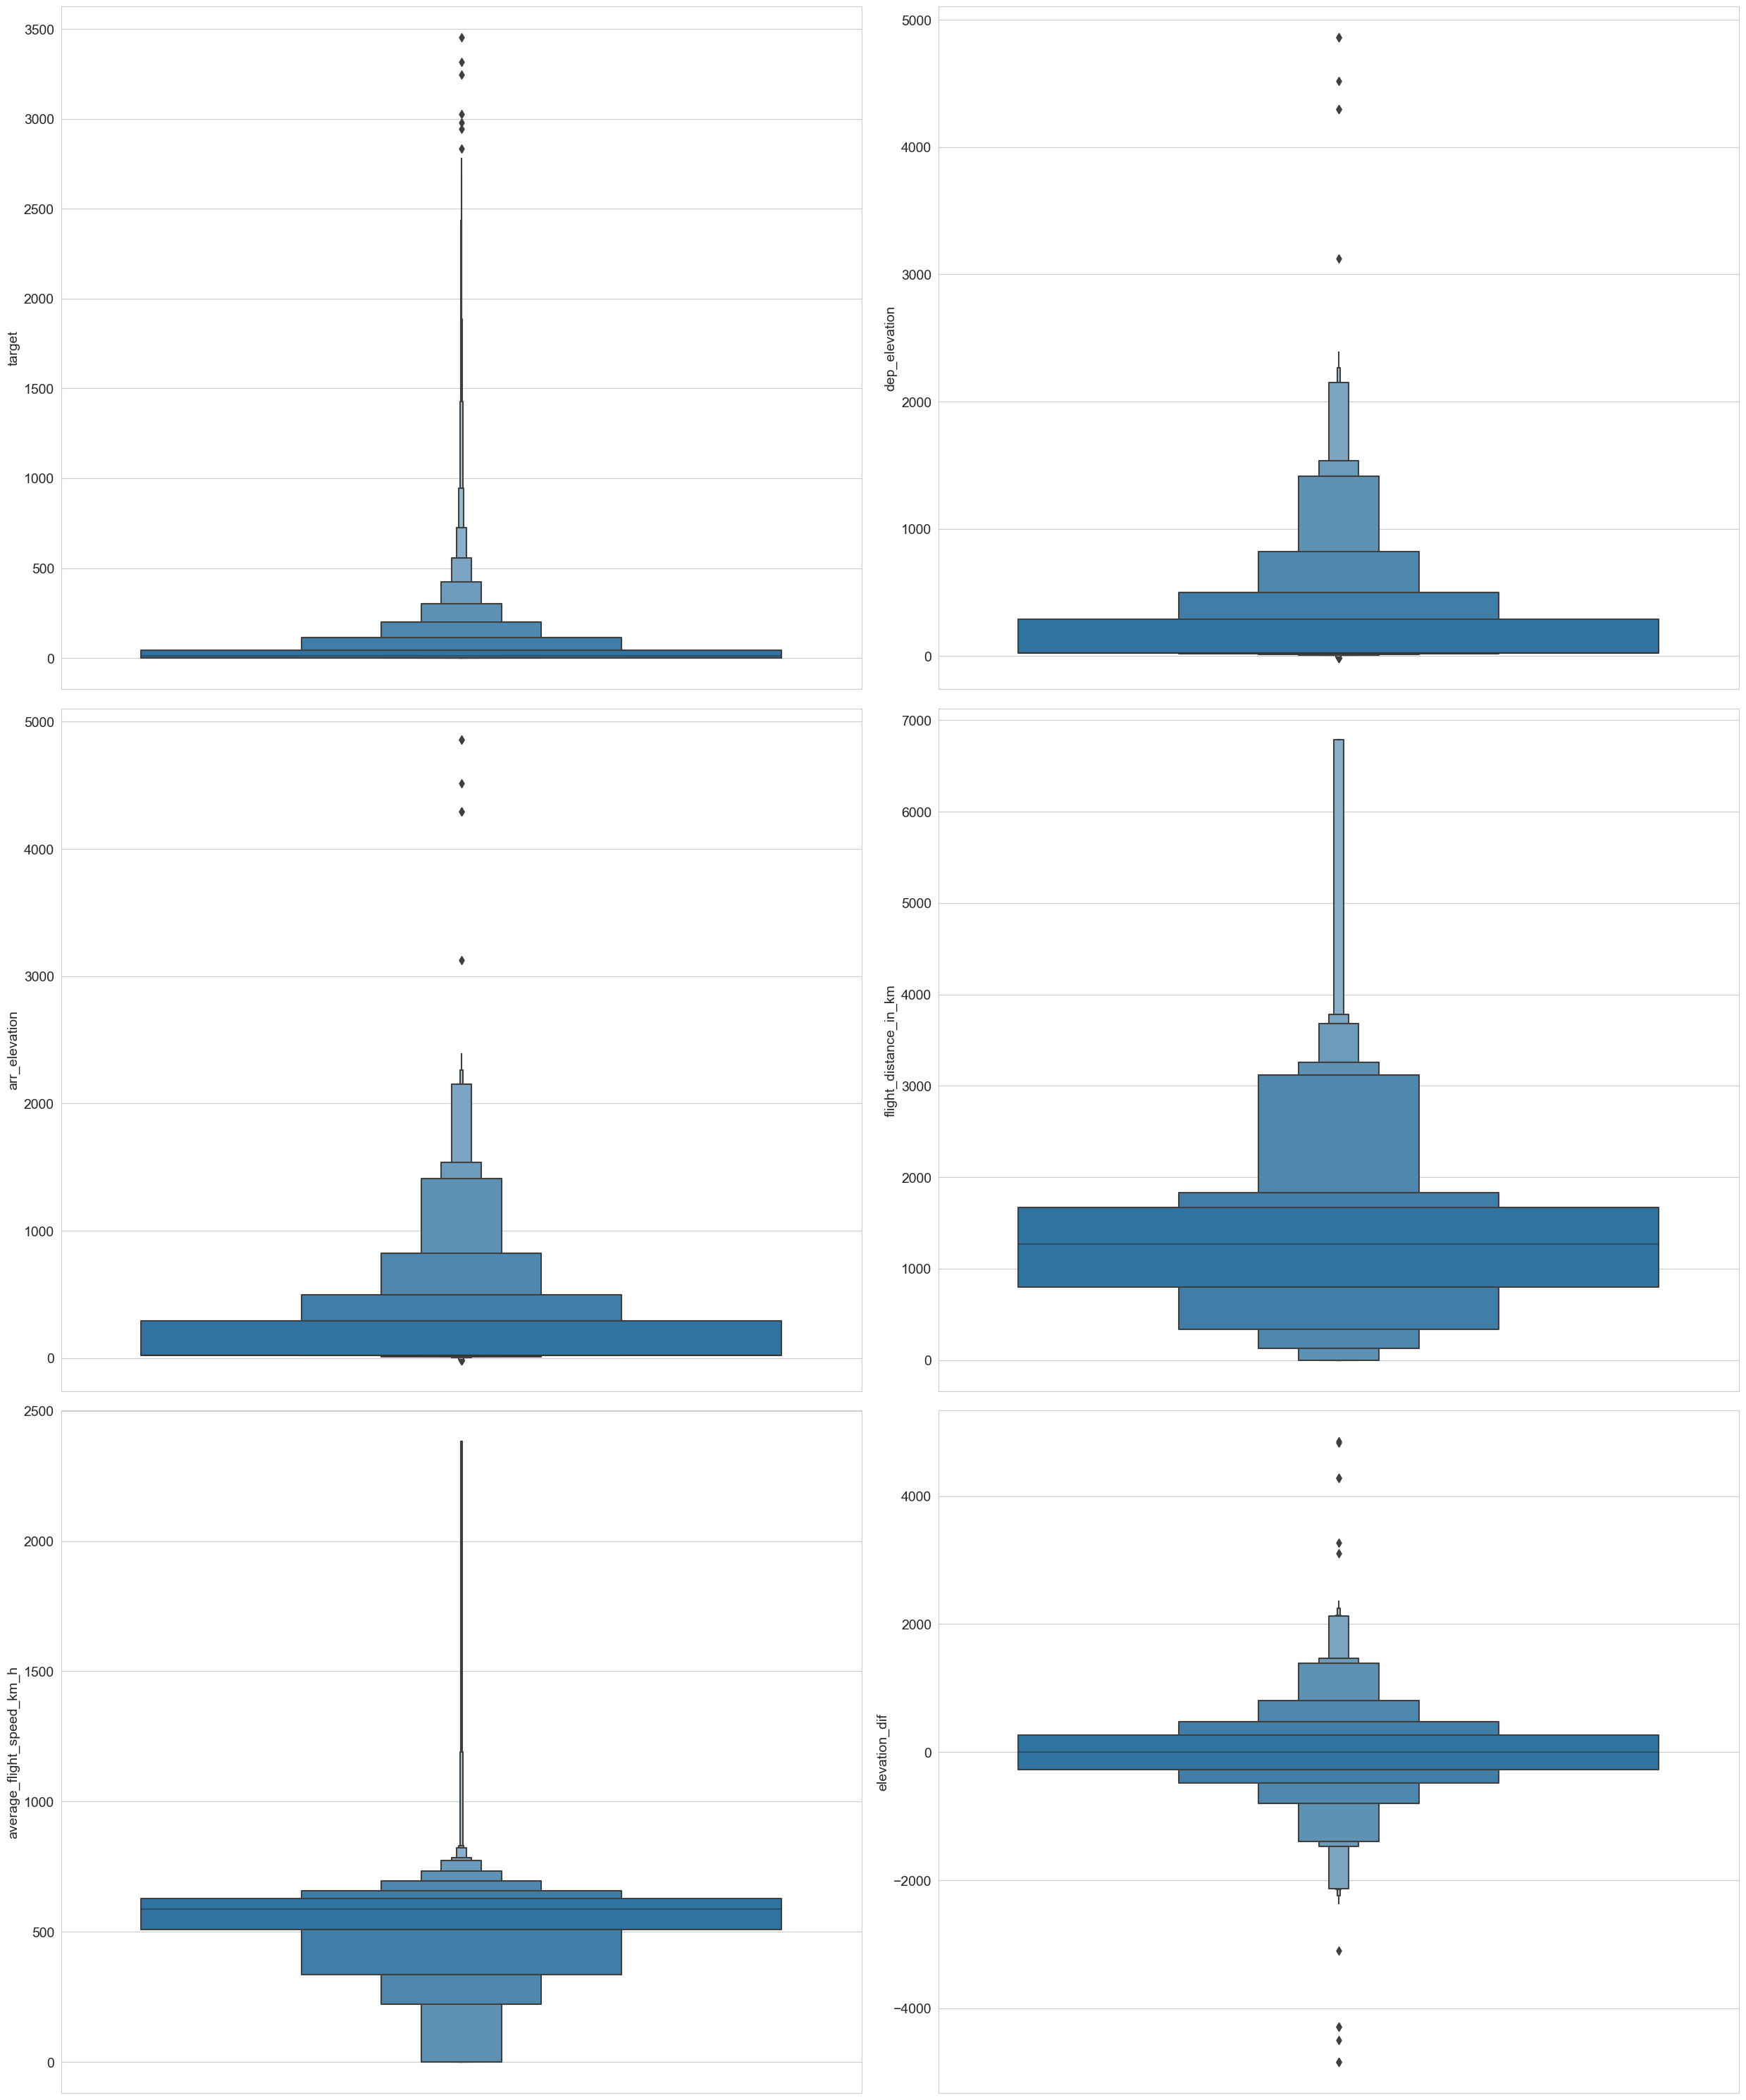

In [27]:
# catoriring 
numerical_columns   = ['target','dep_elevation','arr_elevation','flight_distance_in_km','average_flight_speed_km_h','elevation_dif']
categorical_columns = ['id','fltid','depstn','arrstn','status','ac','dep_iata','arr_iata','arr_country','std','sta','season']

numerical_features   = df[numerical_columns]
categorical_features = df[categorical_columns]
#Univariate Analysis¶

fig = plt.figure(figsize=(25,40))
for i in range(len(numerical_features.columns)):
    fig.add_subplot(4,2,i+1)
    sns.boxenplot( y=numerical_features.iloc[:,i])

plt.tight_layout()
plt.show()

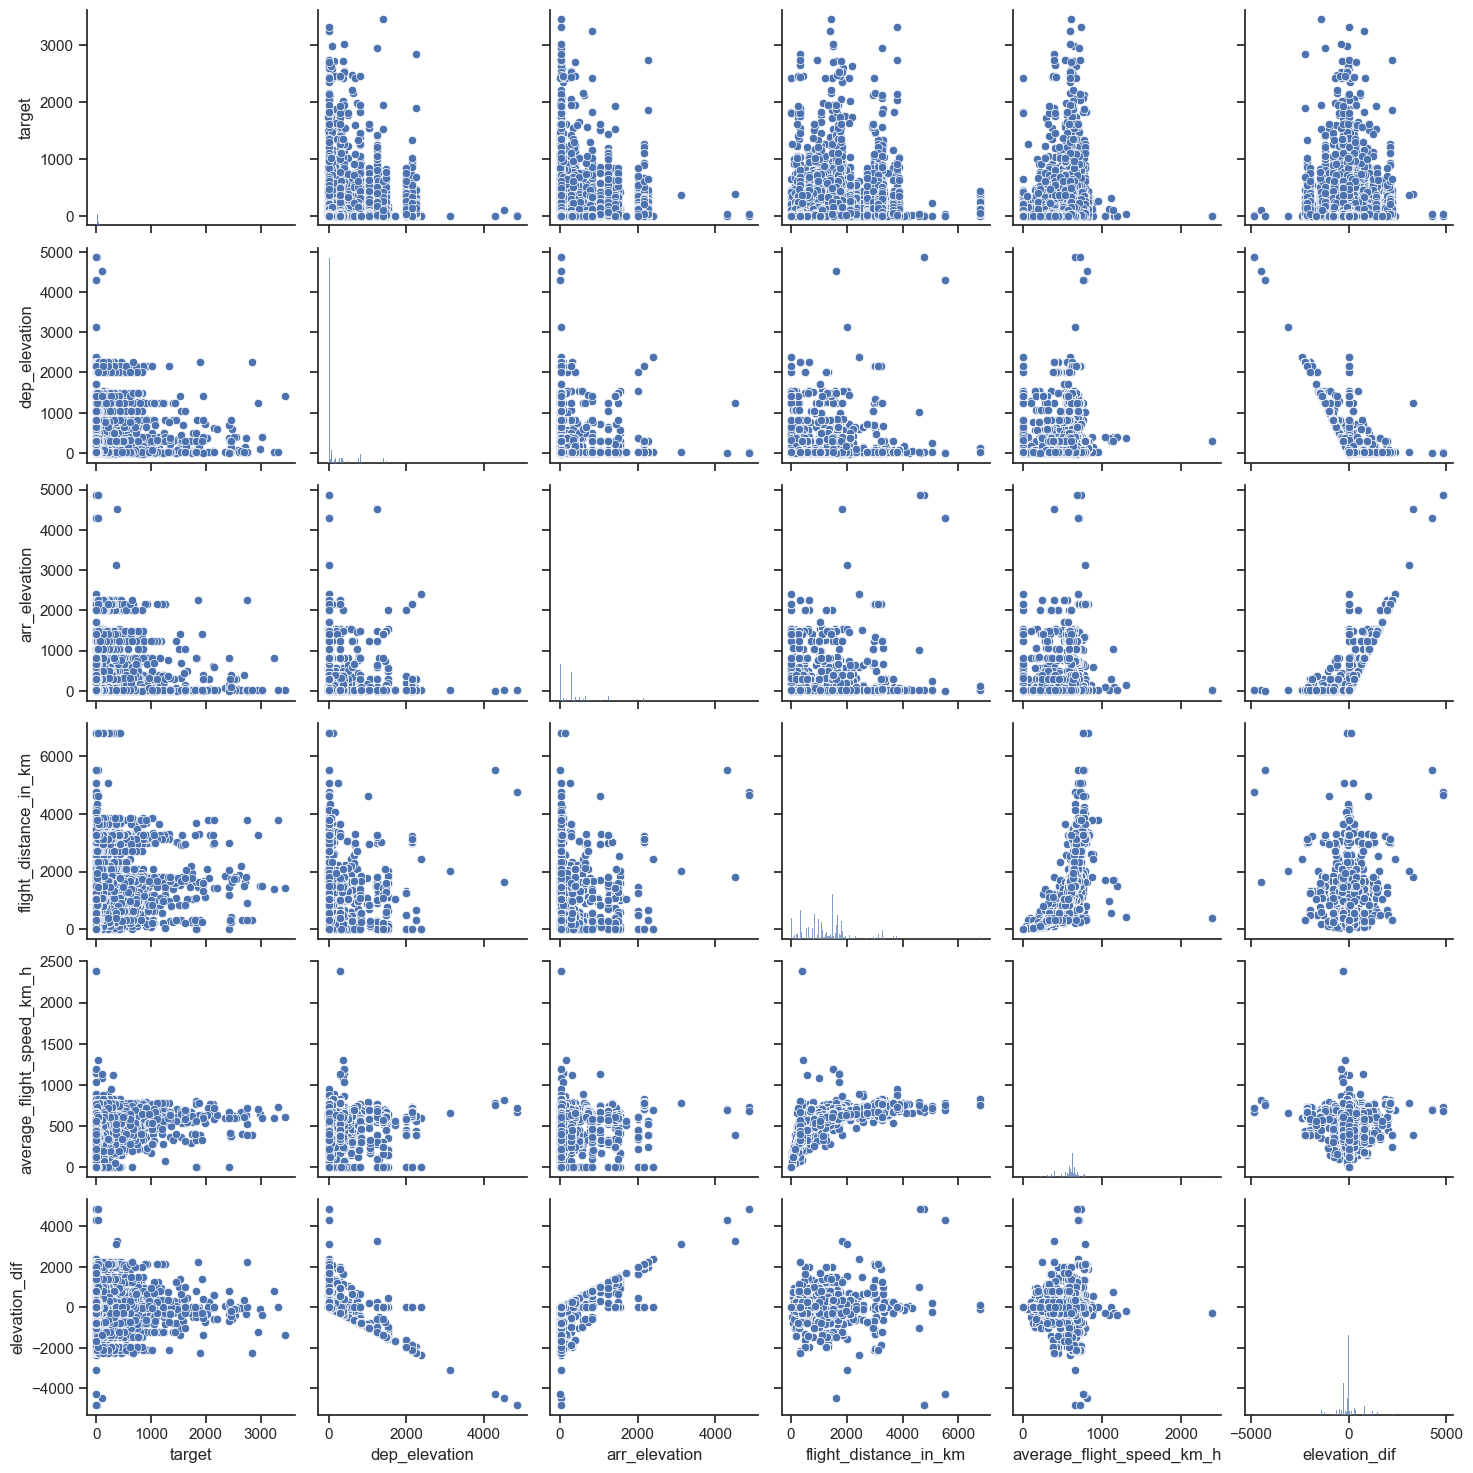

In [28]:


# Set the style for better visualization
sns.set(style="ticks")

# Create a pair plot for numerical features
sns.pairplot(numerical_features)
plt.show()


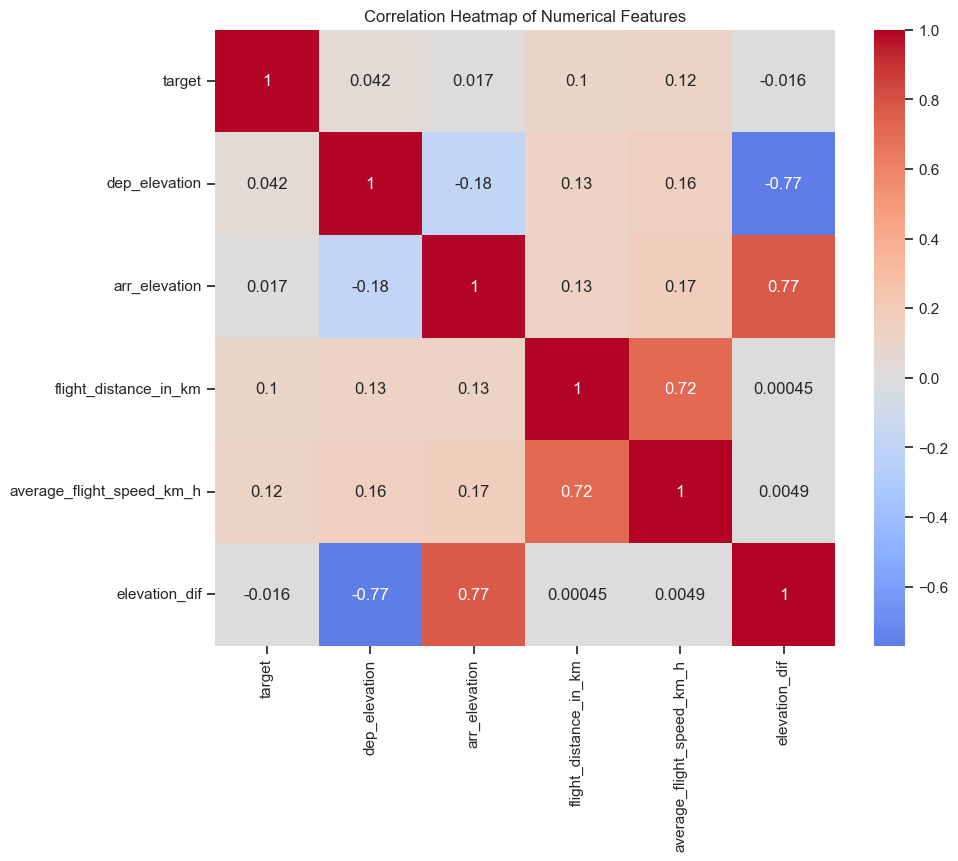

In [29]:

# Calculate the correlation matrix
correlation_matrix = numerical_features.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

plt.title('Correlation Heatmap of Numerical Features')
plt.show()


In [30]:
cleaned_df = df.drop(["id","measurement_date"], axis=1)
# Distributions - helpful to know where to trim the data
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 20))
axs = axs.flatten()
columns_to_plot = ["Age","pregnancies","bmi","insulin","glucose","bloodpressure","diabetespedigreefunction","outcome","skinthickness"]
for index, (column_name, column_data) in enumerate(cleaned_df.items()):
    if index < len(axs):
            # Create a histogram with kernel density estimate
            sns.histplot(data=cleaned_df, x=column_name, kde=True, ax=axs[index])
            axs[index].set_title(column_name)  # Set title for the subplot
            axs[index].set_title(column_name, fontsize=18, pad=10)  # Set title for the subplot
            axs[index].set_xlabel(column_name, fontsize=16)  # Set x-label
            axs[index].set_ylabel("Frequency", fontsize=16)  # Set x-label
            axs[index].tick_params(axis='both', which='both', labelsize=14, width=2, length=6)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

KeyError: "['measurement_date'] not found in axis"

C:\Users\sa3id\AppData\Local\Temp\ipykernel_16140\1633793122.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numerical_features.iloc[:,i].dropna(), rug=True, hist=True, label='UW', kde_kws={'bw':1})
c:\Users\sa3id\spiced\flight_delays_ML\.venv\Lib\site-packages\seaborn\distributions.py:2511: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\sa3id\AppData\Local\Temp\ipykernel_16140\1633793122.py:6

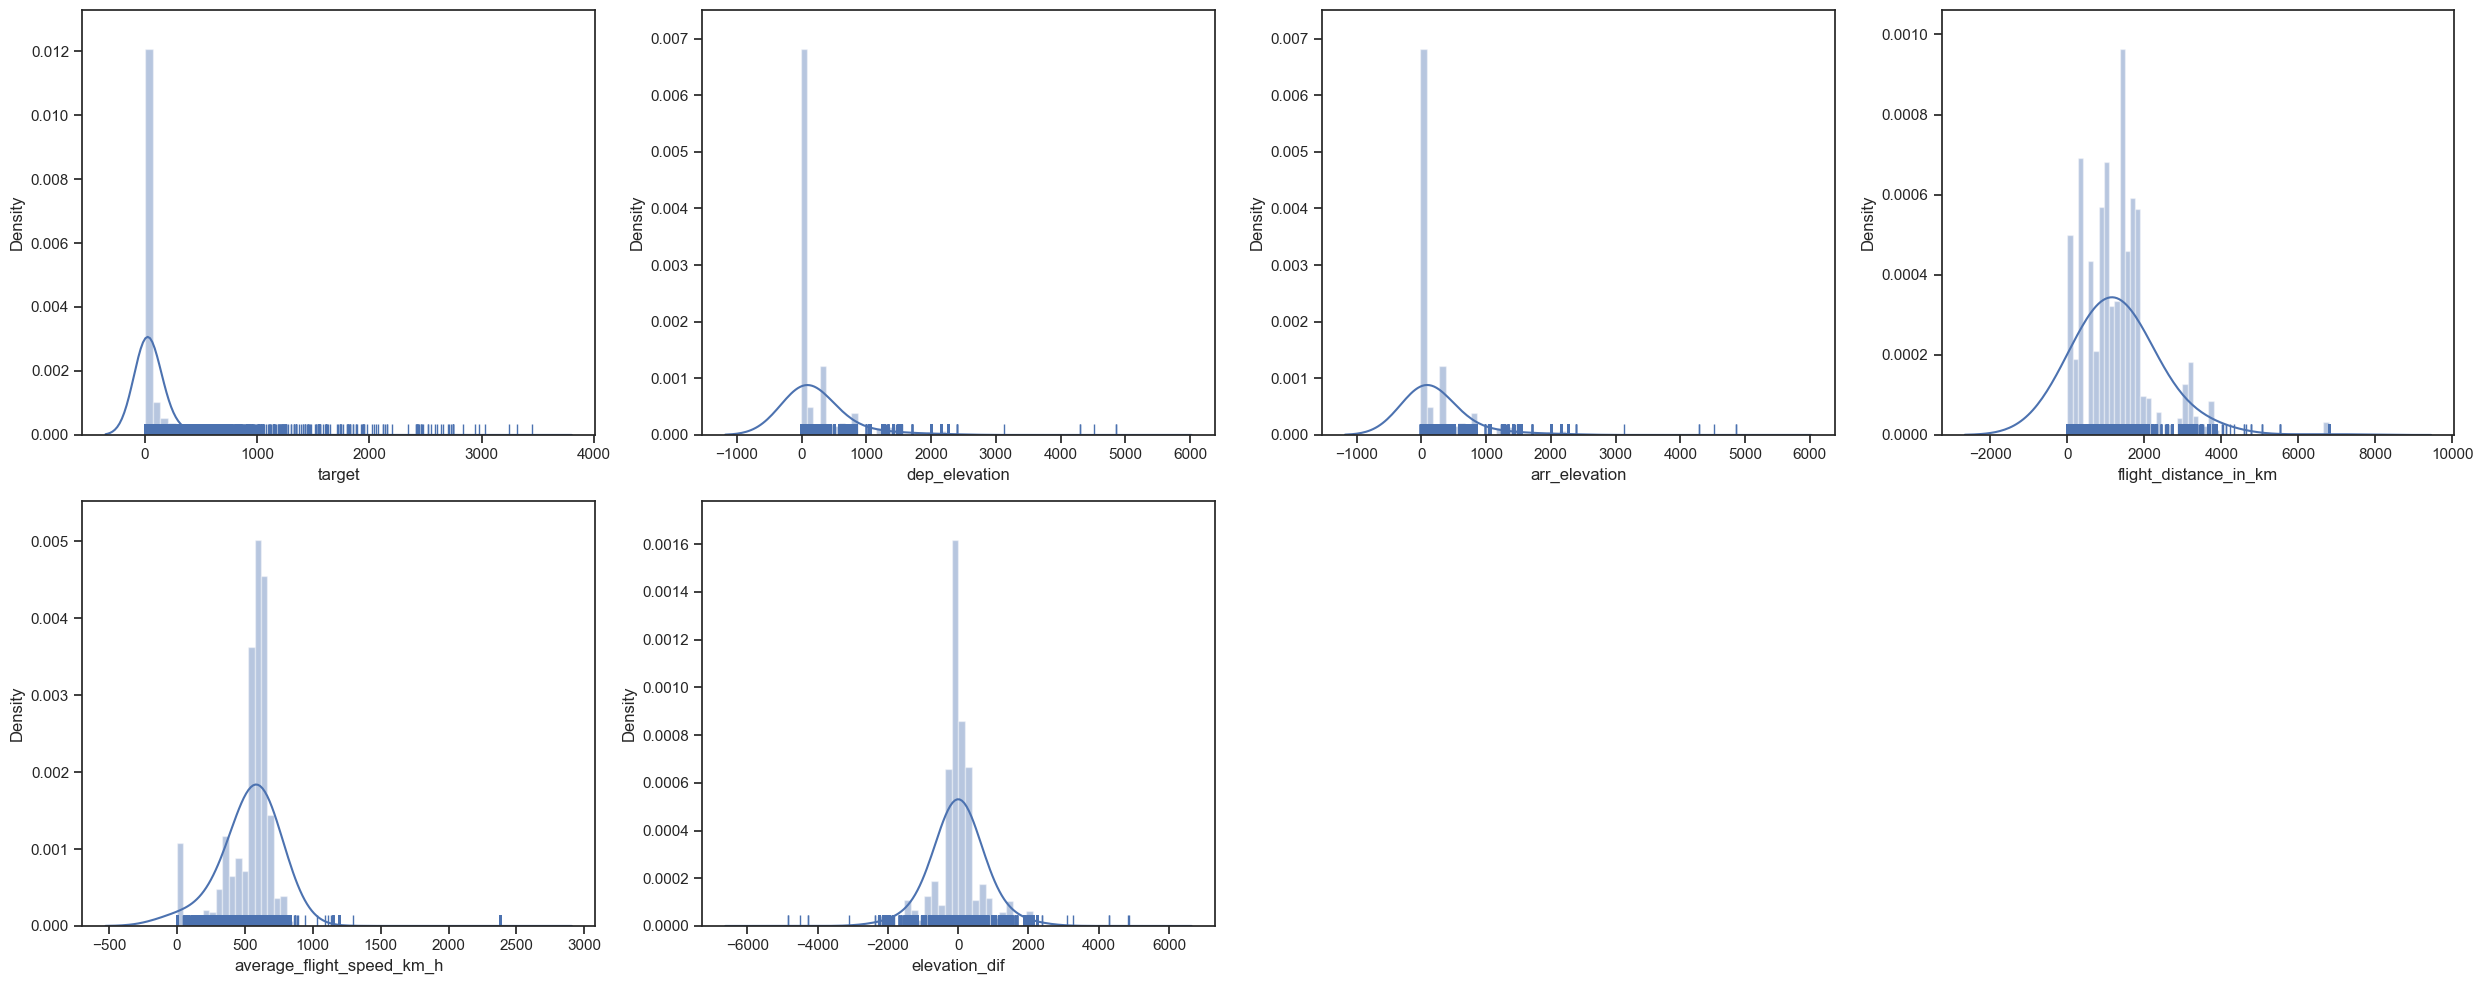

In [ ]:
##Data visualization

fig = plt.figure(figsize=(25, 10))
for i in range(len(numerical_features.columns)):
    fig.add_subplot(2,4,i+1)
    sns.distplot(numerical_features.iloc[:,i].dropna(), rug=True, hist=True, label='UW', kde_kws={'bw':1})
    plt.xlabel(numerical_features.columns[i])
plt.tight_layout()
plt.show()

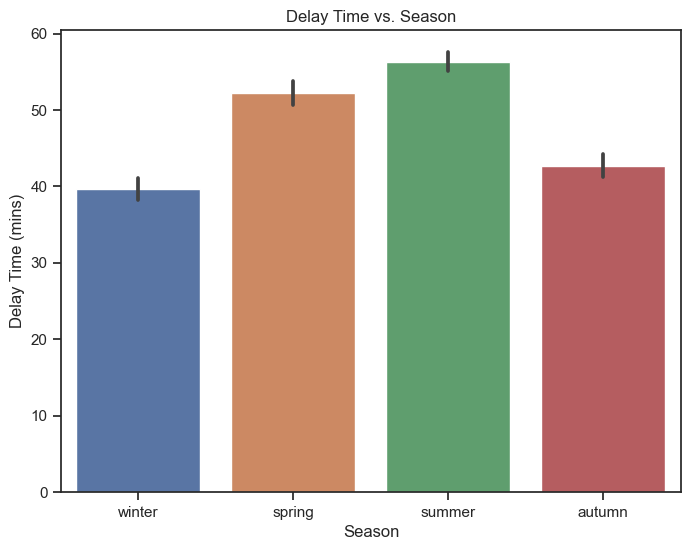

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data (replace this with your actual data)
data = {
    "season": df['season'],
    "target": df['target']
}

df_season = pd.DataFrame(data)

# Create a box plot or violin plot
plt.figure(figsize=(8, 6))
sns.barplot(x="season", y="target", data=df_season)
plt.title("Delay Time vs. Season")
plt.xlabel("Season")
plt.ylabel("Delay Time (mins)")
plt.show()


In [ ]:
df.head()

,id,datop,fltid,depstn,arrstn,std,sta,status,ac,target,...,arr_elevation,arr_lat,arr_lon,airline_code,elevation_dif,flight_time_in_min,flight_distance_in_km,average_flight_speed_km_h,international_flight,season
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,10:30:00,12:55:00,ATA,TU 32AIMN,260.0,...,22.0,36.851002,10.22720,TU,-634.0,145.0,1667,690,1,winter
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,15:05:00,16:55:00,ATA,TU 31BIMO,20.0,...,22.0,36.851002,10.22720,TU,-746.0,110.0,983,536,1,winter
2,train_id_2,2016-01-16,TU 0214,TUN,IST,04:10:00,06:45:00,ATA,TU 32AIMN,0.0,...,325.0,41.275333,28.75200,TU,303.0,155.0,1673,648,1,winter
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,14:10:00,17:00:00,ATA,TU 736IOK,0.0,...,90.0,47.153198,-1.61073,TU,71.0,170.0,1805,637,1,winter
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,14:30:00,15:50:00,ATA,TU 320IMU,22.0,...,82.0,36.691002,3.21541,TU,60.0,80.0,626,470,1,winter


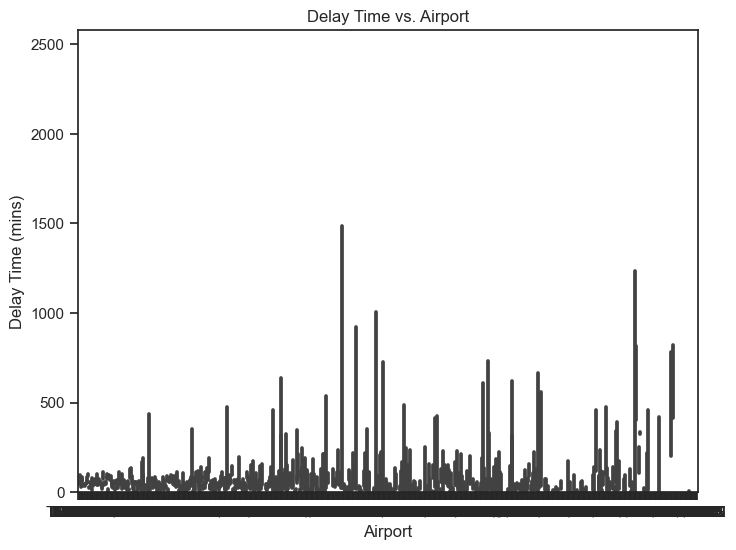

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data (replace this with your actual data)
data = {

    "ariport": df['arrstn'] + df['depstn'],  # Make sure to use double square brackets
    "target": df['target']
}

df_airport = pd.DataFrame(data)

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x="ariport", y="target", data=df_airport)
plt.title("Delay Time vs. Airport")
plt.xlabel("Airport")
plt.ylabel("Delay Time (mins)")
plt.show()


,0,1,2,3,4
id,train_id_0,train_id_1,train_id_2,train_id_3,train_id_4
datop,2016-01-03 00:00:00,2016-01-13 00:00:00,2016-01-16 00:00:00,2016-01-17 00:00:00,2016-01-17 00:00:00
fltid,TU 0712,TU 0757,TU 0214,TU 0480,TU 0338
depstn,CMN,MXP,TUN,DJE,TUN
arrstn,TUN,TUN,IST,NTE,ALG
std,10:30:00,15:05:00,04:10:00,14:10:00,14:30:00
sta,12:55:00,16:55:00,06:45:00,17:00:00,15:50:00
status,ATA,ATA,ATA,ATA,ATA
ac,TU 32AIMN,TU 31BIMO,TU 32AIMN,TU 736IOK,TU 320IMU
target,260.0,20.0,0.0,0.0,22.0
